In [1]:
import math

import fresnel
import freud
import gsd.hoomd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.style.use('ggplot')


OPENMP DISPLAY ENVIRONMENT BEGIN
   _OPENMP='201611'
  [host] OMP_AFFINITY_FORMAT='OMP: pid %P tid %i thread %n bound to OS proc set {%A}'
  [host] OMP_ALLOCATOR='omp_default_mem_alloc'
  [host] OMP_CANCELLATION='FALSE'
  [host] OMP_DEFAULT_DEVICE='0'
  [host] OMP_DISPLAY_AFFINITY='FALSE'
  [host] OMP_DISPLAY_ENV='TRUE'
  [host] OMP_DYNAMIC='FALSE'
  [host] OMP_MAX_ACTIVE_LEVELS='1'
  [host] OMP_MAX_TASK_PRIORITY='0'
  [host] OMP_NESTED: deprecated; max-active-levels-var=1
  [host] OMP_NUM_THREADS: value is not defined
  [host] OMP_PROC_BIND='false'
  [host] OMP_SCHEDULE='static'
  [host] OMP_STACKSIZE='8M'
  [host] OMP_TARGET_OFFLOAD=DEFAULT
  [host] OMP_THREAD_LIMIT='2147483647'
  [host] OMP_TOOL='enabled'
  [host] OMP_TOOL_LIBRARIES: value is not defined
  [host] OMP_TOOL_VERBOSE_INIT: value is not defined
  [host] OMP_WAIT_POLICY='PASSIVE'
OPENMP DISPLAY ENVIRONMENT END




In [2]:
# Grimelipid potential, gives back both energy and force for r, A, B, r0, and rc values
def grimelipid(r, A, B, r0, rc):
    a = np.pi/(2.0*r0)
    b = np.pi/(rc - r0)
    
    f = np.zeros(len(r))
    u = np.zeros(len(r))
    
    for ridx,rin in enumerate(r):
        if rin <= r0:
            C = A/a - 2.0*B/b
            f[ridx] = A*np.cos(rin*a)
            u[ridx] = (-A/a)*np.sin(rin*a)+C
        elif (rin > r0) and (rin <= rc):
            C = (-B/b)
            f[ridx] = B*np.cos(np.pi/2.0 + (rin - r0)*b)
            u[ridx] = (-B/b)*np.sin(np.pi/2.0 + (rin - r0)*b) + C
        else:
            f[ridx] = 0.0
            u[ridx] = 0.0
    return [u, f]

In [3]:
A = 25.0
B = 5.0
r0 = 1.0
rc = 2.0
r = np.linspace(0.0, 2.1, 211)

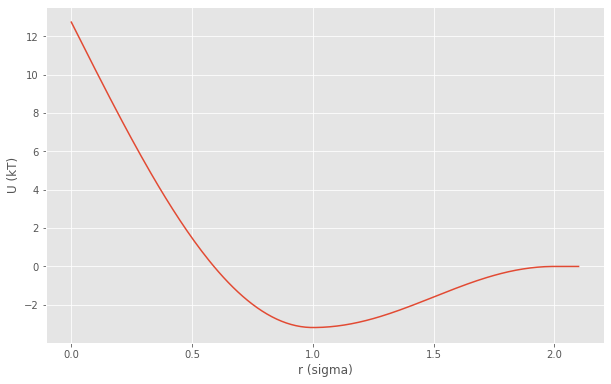

In [4]:
u_gl, f_gl = grimelipid(r, A, B, r0, rc)
fig = plt.figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(r, u_gl)
ax.set_xlabel('r (sigma)')
ax.set_ylabel('U (kT)')
plt.savefig('u_grimelipid.png', bbox_inches='tight')

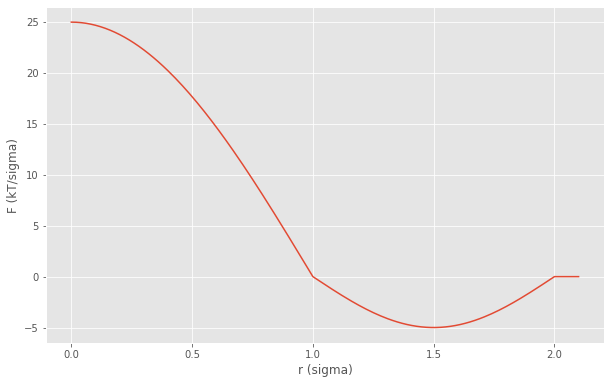

In [5]:
fig = plt.figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(r, f_gl)
ax.set_xlabel('r (sigma)')
ax.set_ylabel('F (kT/sigma)')
plt.savefig('f_grimelipid.png', bbox_inches='tight')

In [6]:
traj = gsd.hoomd.open('../data/20211102/strength_scan/traj_npt_membrane.gsd')

In [7]:
# Figure out the box size for the transform
Lxreal = traj[0].configuration.box[0]
Lyreal = traj[0].configuration.box[1]

# XXX: CJE: This is a hack to get not NAN on the edges of the box
Lx = Lxreal - 4
Ly = Lyreal - 4

# Figure out which are the headgroups from the lipids
nmembrane = 80000
nbeads = 4
nlipids = np.int32(nmembrane / nbeads)
head_idx = np.arange(0,nmembrane,nbeads)
idx_skip = nbeads*2
leaf1_idx = np.arange(0,nmembrane,idx_skip)
leaf2_idx = np.arange(nbeads,nmembrane,idx_skip)

# Figure out the zsum to set the middle of the bilayer
positions = traj[0].particles.position
z1 = positions[leaf1_idx,2]
z2 = positions[leaf2_idx,2]
z0 = (np.sum(z1) + np.sum(z2))/(len(z1)+len(z2))
z1 = z1 - z0
z2 = z2 - z0

# Get the r positions for each bilayer
r1 = positions[leaf1_idx,0:2]
r2 = positions[leaf2_idx,0:2]

In [8]:
# Create the grid for interpolation
grid_x, grid_y = np.mgrid[-Lx/2:Lx/2:100j,-Ly/2:Ly/2:100j]
from scipy.interpolate import griddata
grid_z1 = griddata(r1, z1, (grid_x, grid_y), method='cubic')
grid_z2 = griddata(r2, z2, (grid_x, grid_y), method='cubic')

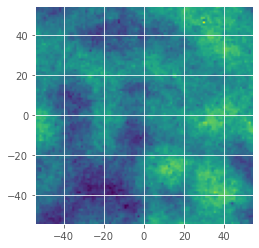

In [9]:
matplotlib.pyplot.imshow(grid_z1.T, extent=(-Lx/2,Lx/2,-Ly/2,Ly/2), origin='lower')

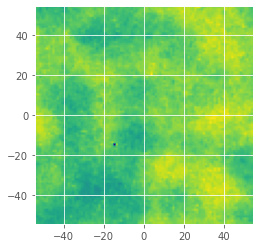

In [10]:
matplotlib.pyplot.imshow(grid_z2.T, extent=(-Lx/2,Lx/2,-Ly/2,Ly/2), origin='lower')

In [11]:
# Take the 2D fourier transform
u1 = np.fft.fft2(grid_z1)
u2 = np.fft.fft2(grid_z2)

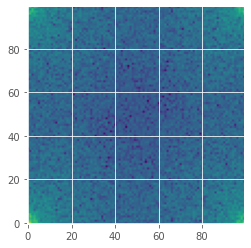

In [12]:
matplotlib.pyplot.imshow(np.log10(np.abs(u1.T)), origin='lower')

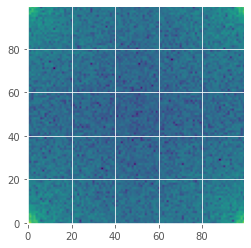

In [13]:
matplotlib.pyplot.imshow(np.log10(np.abs(u2.T)), origin='lower')

q-cutoff: 0.05600242197280403


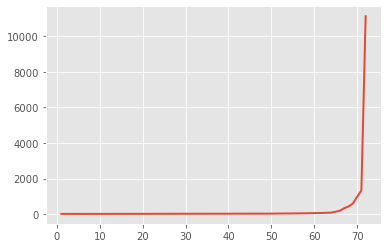

In [14]:
# Now take a radial average of the FFTs
qcutoff = 2.0*np.pi/Lxreal
deltaq = 0.05

print(f"q-cutoff: {qcutoff}")

# Create an XY grid of the qvec points
cen_x = u1.shape[1]/2+1
cen_y = u1.shape[0]/2+1
X,Y = np.meshgrid(np.arange(u1.shape[1]) - cen_x, np.arange(u1.shape[0]) - cen_y)
R = np.sqrt(X**2+Y**2)
rad = np.arange(1, np.max(R), 1)
intensity = np.zeros(len(rad))
index = 0
bin_size = 1
for i in rad:
    mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
    values = np.abs(u1[mask])
    intensity[index] = np.mean(values)
    index += 1
    
# Create figure and add subplot
fig = plt.figure()
ax = fig.add_subplot(111)
# Plot data
ax.plot(rad, intensity, linewidth=2)